# CMPS 290C: Dimensionality Reduction Miniproject

Keller Jordan, Sanjay Krishna Gouda, Brett Gohre, Numra Bathool

We apply t-SNE, LargeVis, and TriMap to the [ISOLET dataset](https://archive.ics.uci.edu/ml/datasets/ISOLET) of spoken letters, and report various metrics of visualization goodness. We also demonstrate an alternative way to copy and shift a dataset that is surprisingly well-visualized by both TriMap and t-SNE.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

# load ISOLET dataset
df1 = pd.read_csv('isolet1+2+3+4.data', header=None)
df2 = pd.read_csv('isolet5.data', header=None)
df = pd.concat([df1, df2], axis=0)
X = np.array(df.iloc[:, :-1])
labels = np.array(df.iloc[:, -1])

# min-max scale, zero-center, and reduce dataset to top 50 SVD components
X -= np.min(X)
X /= np.max(X)
X -= np.mean(X, axis=0)
X = TruncatedSVD(n_components=50, random_state=0).fit_transform(X)

In [2]:
from sklearn.manifold import TSNE
import trimap # PyTorch implementation of TriMap for fast GPU embedding

# embed into 2D space using t-SNE, LargeVis, and TriMap
Y_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=2000).fit_transform(X)
Y_largevis = None # TODO
Y_trimap = trimap.embed(X)

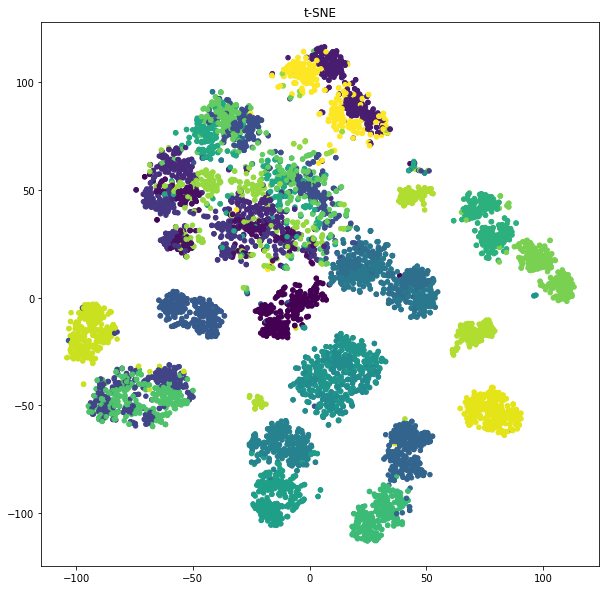

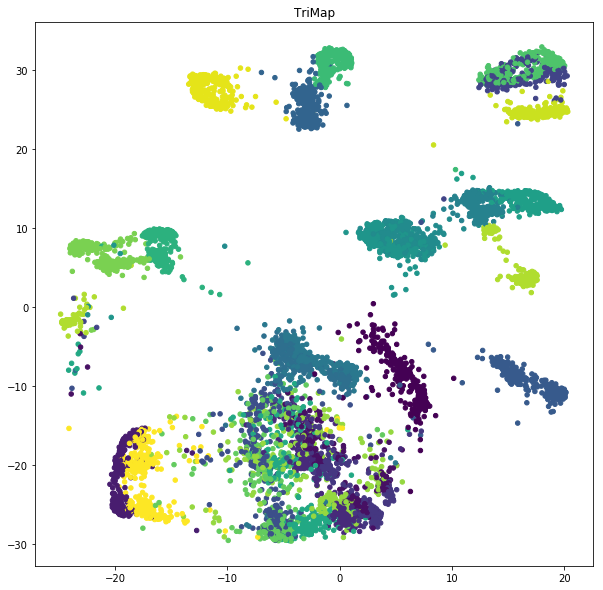

In [3]:
import matplotlib.pyplot as plt

def plot_embedding(Y, labels, title):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
    plt.title(title)

plot_embedding(Y_tsne, labels, title='t-SNE')
# plot_embedding(Y_largevis, labels) # TODO
plot_embedding(Y_trimap, labels, title='TriMap')
plt.show()

# Metric Evaluation

Using logspace to interpolate through neighborhood sizes

In [4]:
from importlib import reload
import metrics
reload(metrics)

from metrics import Metrics
from sklearn.neighbors import NearestNeighbors as knn

_, nbrs_input = knn(n_neighbors=X.shape[0]).fit(X).kneighbors(X)

metrics_tsne = Metrics(nbrs_input, Y_tsne)
# metrics_largevis = Metrics(nbrs_input, Y_largevis) # TODO
metrics_trimap = Metrics(nbrs_input, Y_trimap)

In [5]:
tp_tsne, fp_tsne = metrics_tsne.roc_metrics()
precision_tsne, recall_tsne = metrics_tsne.mean_precision_recall()
trust_tsne, cont_tsne = metrics_tsne.trustworthiness_continuity()
# tp_largevis, fp_largevis = metrics_largevis.roc_metrics()
# precision_largevis, recall_largevis = metrics_largevis.mean_precision_recall()
# trust_largevis, cont_largevis = metrics_largevis.trustworthiness_continuity()
tp_trimap, fp_trimap = metrics_trimap.roc_metrics()
precision_trimap, recall_trimap = metrics_trimap.mean_precision_recall()
trust_trimap, cont_trimap = metrics_trimap.trustworthiness_continuity()

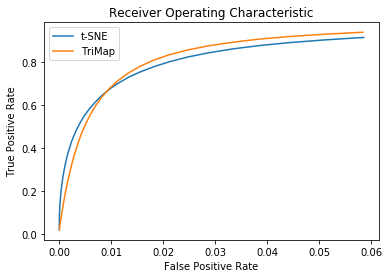

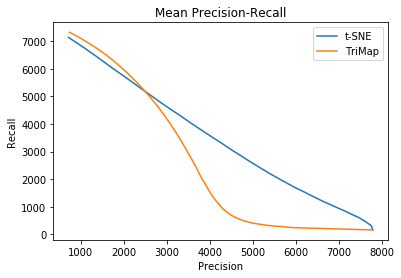

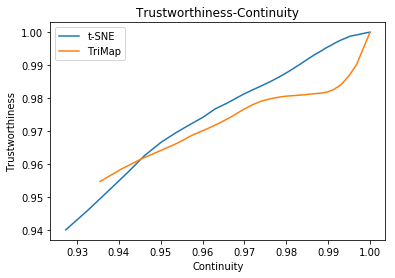

In [6]:
plt.figure()
plt.plot(fp_tsne, tp_tsne, label='t-SNE')
# plt.plot(fp_largevis, tp_largevis, label='LargeVis')
plt.plot(fp_trimap, tp_trimap, label='TriMap')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

plt.figure()
plt.plot(precision_tsne, recall_tsne, label='t-SNE')
# plt.plot(precision_largevis, recall_largevis, label='LargeVis')
plt.plot(precision_trimap, recall_trimap, label='TriMap')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Mean Precision-Recall')
plt.legend()

plt.figure()
plt.plot(cont_tsne, trust_tsne, label='t-SNE')
# plt.plot(precision_largevis, recall_largevis, label='LargeVis')
plt.plot(cont_trimap, trust_trimap, label='TriMap')
plt.xlabel('Continuity')
plt.ylabel('Trustworthiness')
plt.title('Trustworthiness-Continuity')
plt.legend()

plt.show()

# Another Invariance

In the TriMap paper, we saw that when a copy of the dataset is concatenated with all dimensions shifted by a fixed value, only TriMap succeeds in displaying the large-scale structure correctly. Another way to "shift" the dataset is to move the image "left" or "right" in the original space, by widening each image either by adding zeros to the left or right side. We then see that surprisingly, t-SNE and TriMap are both able to visualize this large-scale structure.

In [7]:
X = np.loadtxt('data/mnist2500_X.txt')
labels = np.loadtxt('data/mnist2500_labels.txt')

n, dim = X.shape
side = int(dim**.5)
X = X.reshape(n, side, side)

# X1: shifted 10 pixels to the left
X1 = np.ones((n, 38, 28))
# X2: shifted 10 pixels to the right
X2 = np.ones((n, 38, 28))

X1[:, :-10, :] = X
X2[:, 10:, :] = X

X1 = X1.reshape(n, 38*28)
X2 = X2.reshape(n, 38*28)

X = np.concatenate((X1, X2), 0)
labels = np.concatenate((labels.copy(), labels.copy()), 0)

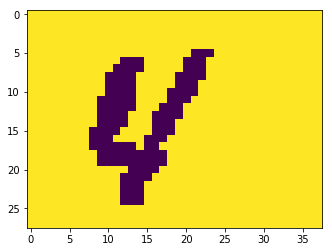

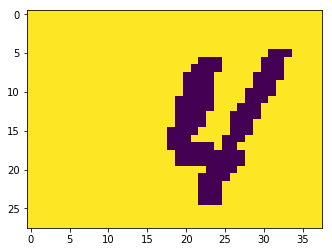

In [8]:
plt.figure()
plt.imshow(X[700].reshape(38, 28).T)
plt.figure()
plt.imshow(X[700+2500].reshape(38, 28).T)
plt.show()

In [9]:
Y_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=2000, verbose=False).fit_transform(X)
Y_largevis = None
Y_trimap = trimap.embed(X, verbose=False)

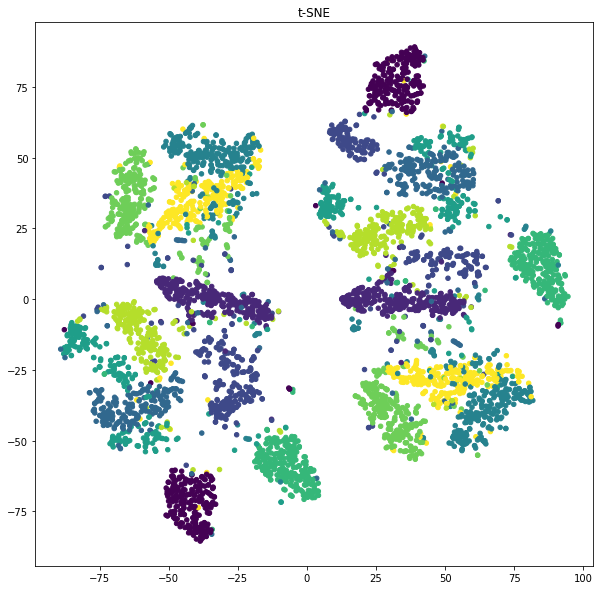

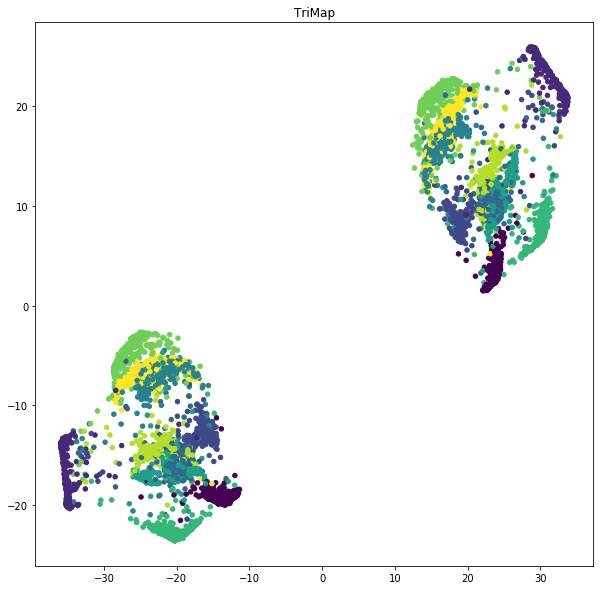

In [10]:
plot_embedding(Y_tsne, labels, title='t-SNE')
plot_embedding(Y_trimap, labels, title='TriMap')
plt.show()

Both TriMap and t-SNE are able to separate the data into two similarly structure copies. TriMap creates a wider division, and the two copies have more structural similarity.